In [5]:
from util import *
import torch
import matplotlib.pyplot as plt

In [2]:
client = gpt4_v_helper()

OPENAI KEY SET

### SoM

In [3]:
# semantic sam
from semantic_sam.BaseModel import BaseModel
from semantic_sam import build_model
from semantic_sam.utils.dist import init_distributed_mode
from semantic_sam.utils.arguments import load_opt_from_config_file
from semantic_sam.utils.constants import COCO_PANOPTIC_CLASSES
from task_adapter.semantic_sam import inference_semsam_m2m_auto


/home/rilab/.pyenv/versions/3.10.12/envs/vgpt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
semsam_cfg = "./config/sesam.yaml"
semsam_ckpt = "./ckpt/swinl_only_sam_many2many.pth"
opt_semsam = load_opt_from_config_file(semsam_cfg)

In [5]:
model_semsam = BaseModel(opt_semsam, build_model(opt_semsam)).from_pretrained(semsam_ckpt).eval().cuda()

/home/rilab/.pyenv/versions/3.10.12/envs/vgpt/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([2])


In [19]:
label_mode = 'Number'
alpha = 0.1
anno_mode = ["Mark","Mask"] # ["Mark", "Mask", "Box"]
text_size, hole_scale, island_scale=640,100,100

(1280, 720)


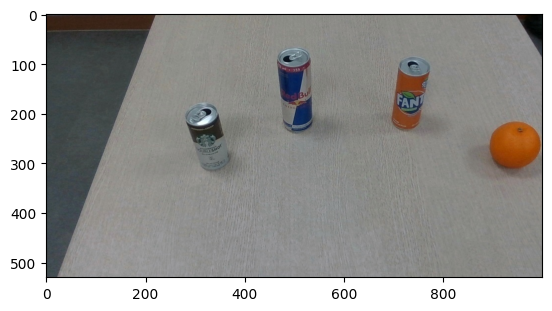

In [20]:
from PIL import Image
image = Image.open("./ori_3.png")
print(image.size)
image = image.crop((100,100,1100,630))

plt.figure()
plt.imshow(image)
plt.show()

In [21]:
level = [2]
semantic = False
text_size, hole_scale, island_scale=720,100,100
text, text_part, text_thresh = '','','0.0'

In [22]:
output, mask = inference_semsam_m2m_auto(model_semsam, image, level, \
                                         text, text_part, text_thresh, text_size, hole_scale, island_scale, semantic, \
                                            label_mode=label_mode, alpha=alpha, anno_mode=anno_mode)

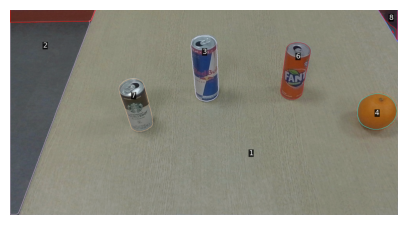

In [23]:
plt.figure(figsize=(5,5))
plt.imshow(output)
plt.axis('off')
# plt.savefig("./output.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [24]:
output = Image.fromarray(output)
output.save("./images/output.png")

### GPT4-V

In [25]:
system_prompt ="""
You need to generate the scene graph for the following image.
e.g., 
Node: 1. [object id]
        - attribute: color, size, shape, brand_name
      2. [object id]
        - attribute: color, size, shape
Edge: 1. [obj 1] is [{spatial relationship 1}, {spatial relationship 2}] of [obj 2]

note: spatial relationship can be one of the following
left, right, on top of, below, in front of, behind
Try to list up all the relationships between the objects.
Brand name should be a proper noun.
The object id is a number written on the object.
"""

In [26]:
client.reset()
client.set_system_prompt(system_prompt)
ans = client.ask("can you name the number in ID patch of the objects on the table?", image_paths = ['./images/output.png'])
printmd(ans)

{'role': 'assistant', 'content': 'The objects on the table have the following ID numbers:\n\n- The can on the left has the ID number 7.\n- The can in the middle has the ID number 3.\n- The can on the right has the ID number 6.\n- The orange has the ID number 4.'}


The objects on the table have the following ID numbers:

- The can on the left has the ID number 7.
- The can in the middle has the ID number 3.
- The can on the right has the ID number 6.
- The orange has the ID number 4.

In [27]:
ans = client.ask("Build the scene graph with the objects only on the table", image_paths = ['./images/output.png'])
printmd(ans)

{'role': 'assistant', 'content': 'Node:\n1. [7]\n   - attribute: color (brown), size (small), brand_name (Starbucks)\n2. [3]\n   - attribute: color (blue), size (small), brand_name (Red Bull)\n3. [6]\n   - attribute: color (orange), size (small), brand_name (Fanta)\n4. [4]\n   - attribute: color (orange), size (small), shape (round)\n\nEdge:\n1. [7] is left of [3]\n2. [7] is far left of [6]\n3. [7] is left of [4]\n4. [3] is right of [7]\n5. [3] is left of [6]\n6. [3] is far left of [4]\n7. [6] is right of [7]\n8. [6] is right of [3]\n9. [6] is left of [4]\n10. [4] is right of [7]\n11. [4] is far right of [3]\n12. [4] is right of [6]'}


Node:
1. [7]
   - attribute: color (brown), size (small), brand_name (Starbucks)
2. [3]
   - attribute: color (blue), size (small), brand_name (Red Bull)
3. [6]
   - attribute: color (orange), size (small), brand_name (Fanta)
4. [4]
   - attribute: color (orange), size (small), shape (round)

Edge:
1. [7] is left of [3]
2. [7] is far left of [6]
3. [7] is left of [4]
4. [3] is right of [7]
5. [3] is left of [6]
6. [3] is far left of [4]
7. [6] is right of [7]
8. [6] is right of [3]
9. [6] is left of [4]
10. [4] is right of [7]
11. [4] is far right of [3]
12. [4] is right of [6]

### Image Edit

In [6]:
ori_img = Image.open("./images/ori_1.png")
ori_img = ori_img.convert("RGBA")

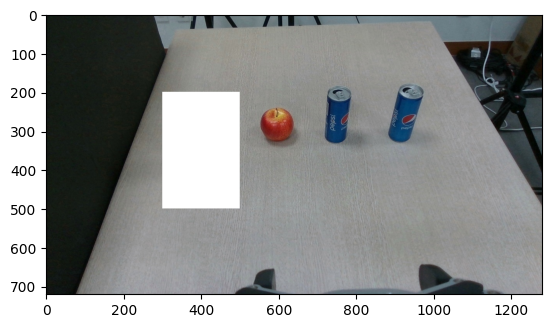

In [7]:
# put your mask box here
mask_boxs = [[300,200,500,500]]
h_ori,w_ori = ori_img.size
mask = copy.deepcopy(ori_img)
mask = np.array(mask)
for mask_box in mask_boxs:
    mask[mask_box[1]:mask_box[3],mask_box[0]:mask_box[2],-1] = 0
plt.figure()
plt.imshow(mask)
plt.show()

In [8]:
text = "A coke can on the table"

In [9]:
ori_img_np = np.array(ori_img)
res = client.image_edit_with_text(
    ori_img_np,
    mask_boxs,
    text, 
    path = './images',
    num=1
)

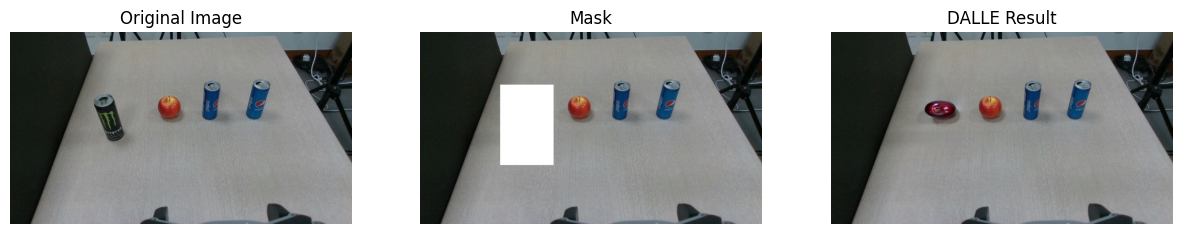

In [18]:
plt.figure(figsize=(5*len(res)+10,5))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(ori_img)
plt.axis('off')
plt.subplot(1,3,2)
plt.title("Mask")
plt.imshow(mask)
plt.axis("off")
for i in range(len(res)):
    plt.subplot(1,len(res)+2,i+3)
    plt.title("DALLE Result")
    plt.imshow(res[i])
    plt.axis('off')
plt.savefig('./images/dalle.png', bbox_inches='tight')
plt.show()